In [1]:
"""odr-fit.py performs ODR fit on data with uncertainties in both the x and y.

It reads data from a CSV file, performs the Orthogonal Distance Regression
(ODR) analysis, and creates plots for the data with fit, residuals, and
parameter correlation ellipses.
"""

'odr-fit.py performs ODR fit on data with uncertainties in both the x and y.\n\nIt reads data from a CSV file, performs the Orthogonal Distance Regression\n(ODR) analysis, and creates plots for the data with fit, residuals, and\nparameter correlation ellipses.\n'

In [2]:
import sys
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
from matplotlib.axes import Axes
from matplotlib.patches import Ellipse, Patch
from scipy import odr, stats

In [3]:
def read_data_from_csv(filename):
    """Read x, y coordinates and their uncertainties from a CSV file.
    
    Parameters
    ----------
    filename : str
        Path to the CSV file. File must contain columns 'x', 'dx', 'y', 'dy'
        where dx and dy represent uncertainties in x and y values.
    """
    try:
        df = pd.read_csv(filename)
        x = df["x"].to_numpy()  
        dx = df["dx"].to_numpy()
        y = df["y"].to_numpy()
        dy = df["dy"].to_numpy()
        return x, dx, y, dy
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

In [4]:
def linear_func(p, x):
    """Compute a linear function of the form y = mx + b.

    Parameters
    ----------
    p : array-like, shape (2,)
        Parameters of the linear function:
        - p[0] (m): slope
        - p[1] (b): y-intercept
    x : array-like
        Independent variable values

    Returns
    -------
    array-like
        Computed y values: m*x + b

    """
    m, b = p
    return m * x + b

In [5]:
def parabolic_func(p, x):
    """Compute a parablic function.

    Parameters
    ----------
    p : array-like, shape (3,)
        Parameters of the linear function:
    x : array-like
        Independent variable values

    Returns
    -------
    array-like
        Computed y values: p[0] + p[1] * x + p[2] * x**2

    """
    return p[0] + p[1] * x + p[2] * x**2

In [6]:
def linear_odr(x, dx, y, dy):
    """Orthogonal Distance Regression analysis on data with uncertainties.

    Fits a linear model to data points with uncertainties in both x and y
    using ODR method from scipy.odr. Also computes goodness-of-fit statistics.

    Parameters
    ----------
    x : array-like
        X coordinates of the data points
    dx : array-like
        Uncertainties (standard deviations) in x coordinates
    y : array-like
        Y coordinates of the data points
    dy : array-like
        Uncertainties (standard deviations) in y coordinates

    Returns
    -------
    results : ODR
        ODR result object containing fit parameters and covariance matrix
    chi_square : float
        Chi-square statistic of the fit
    degrees_freedom : int
        Number of degrees of freedom (n_points - n_parameters)
    chi_square_reduced : float
        Reduced chi-square (chi-square / degrees_freedom)
    p_value : float
        P-value for the chi-square goodness-of-fit test

    Notes
    -----
    Uses a linear function model: y = mx + b
    Initial parameter guesses are [m=1.0, b=0.0]

    """
    linear = odr.Model(linear_func)
    data = odr.RealData(x, y, sx=dx, sy=dy)
    odr_obj = odr.ODR(data, linear, beta0=[1.0, 0.0])
    results = odr_obj.run()

    degrees_freedom = len(x) - 2
    chi_square = results.sum_square  # type: ignore # ODR Output attribute exists at runtime
    chi_square_reduced = chi_square / degrees_freedom
    p_value = float(1 - stats.chi2.cdf(chi_square, degrees_freedom))

    return results, chi_square, degrees_freedom, chi_square_reduced, p_value

In [7]:
def perform_odr(x, dx, y, dy, model_func, beta0):
    """Orthogonal Distance Regression analysis on data with uncertainties.

    Fits a given model function to data points with uncertainties in both x and y
    using ODR method from scipy.odr. Also computes goodness-of-fit statistics.

    Parameters
    ----------
    x : array-like
        X coordinates of the data points
    dx : array-like
        Uncertainties (standard deviations) in x coordinates
    y : array-like
        Y coordinates of the data points
    dy : array-like
        Uncertainties (standard deviations) in y coordinates
    model_func : callable
        Model function to fit. Should take parameters (beta, x) where beta is
        the parameter vector and x is the independent variable array
    beta0 : array-like
        Initial guesses for the model parameters

    Returns
    -------
    results : ODR
        ODR result object containing fit parameters and covariance matrix
    chi_square : float
        Chi-square statistic of the fit
    degrees_freedom : int
        Number of degrees of freedom (n_points - n_parameters)
    chi_square_reduced : float
        Reduced chi-square (chi-square / degrees_freedom)
    p_value : float
        P-value for the chi-square goodness-of-fit test

    """
    model = odr.Model(model_func)
    data = odr.RealData(x, y, sx=dx, sy=dy)
    odr_obj = odr.ODR(data, model, beta0=beta0)
    results = odr_obj.run()

    n_params = len(beta0)
    degrees_freedom = len(x) - n_params
    chi_square = results.sum_square  # type: ignore # ODR Output attribute exists at runtime
    chi_square_reduced = chi_square / degrees_freedom
    p_value = float(1 - stats.chi2.cdf(chi_square, degrees_freedom))

    return results, chi_square, degrees_freedom, chi_square_reduced, p_value

In [8]:
def plot_fit(x, dx, y, dy, results, save_path):
    """Create and save a plot of data points with error bars and fit line.

    Parameters
    ----------
    x : array-like
        X-coordinates of the data points
    dx : array-like
        Uncertainties (standard deviations) in x-coordinates
    y : array-like
        Y-coordinates of the data points
    dy : array-like
        Uncertainties (standard deviations) in y-coordinates
    results : scipy.odr.Output
        Results from ODR (Orthogonal Distance Regression) fit
    save_path : str or Path
        Path where the plot will be saved

    Notes
    -----
    - Automatically switches between point markers and error bars only, based on
    the relative size of uncertainties compared to data range
    - Uses error bars when median uncertainty > 1% of data range
    - Generates fit line using 100 evenly spaced points
    - Creates a 10x8 inch figure with grid
    - Saves plot and closes figure after completion

    """
    plt.figure(figsize=(10, 8))

    # Determine if error bars are visible
    median_dx = np.median(dx)
    median_dy = np.median(dy)
    x_range = np.max(x) - np.min(x)
    y_range = np.max(y) - np.min(y)

    use_points = (median_dx / x_range < 0.01) and (median_dy / y_range < 0.01)
    marker = "o" if use_points else "none"

    plt.errorbar(x, y, xerr=dx, yerr=dy, fmt=marker, label="Data")

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = linear_func(results.beta, x_fit)
    plt.plot(x_fit, y_fit, "r-", label="Fit")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("ODR Fit with Uncertainties")
    plt.legend()
    plt.grid(True)

    plt.savefig(save_path)
    plt.show()
    plt.close()

In [9]:
def plot_residuals(x, dx, y, dy, results, save_path):
    """Generate and save residuals plot for a linear fit with uncertainties.

    Creates a figure showing the difference between observed and model values,
    including total uncertainty from both y and x errors. Automatically adjusts
    the plot style based on the relative size of error bars.

    Parameters
    ----------
    x : array-like
        Independent variable values
    dx : array-like
        Uncertainties in x values
    y : array-like
        Dependent variable values (observations)
    dy : array-like
        Uncertainties in y values
    results : object
        Fit results containing at least:
            - beta: array-like with [slope, intercept]
    save_path : str or Path
        Output path where the plot will be saved

    Notes
    -----
    - Total uncertainty combines y errors (dy) and propagated x errors
    - Points are shown only if median uncertainty is < 1% of residual range
    - Plot includes a red horizontal line at y=0 for reference
    - Figure is automatically closed after saving

    The plot shows:
    - Residuals (y - model) vs x
    - Error bars showing combined uncertainty
    - Grid for better readability

    """
    plt.figure(figsize=(10, 6))

    y_model = linear_func(results.beta, x)
    residuals = y - y_model
    total_uncertainty = np.sqrt(dy**2 + (results.beta[0] * dx) ** 2)

    # Determine if error bars are visible
    median_uncert = np.median(total_uncertainty)
    resid_range = np.max(residuals) - np.min(residuals)
    use_points = median_uncert / resid_range < 0.01
    marker = "o" if use_points else "none"

    plt.errorbar(x, residuals, yerr=total_uncertainty, fmt=marker)
    plt.axhline(y=0, color="r", linestyle="-")
    plt.xlabel("X")
    plt.ylabel("Residuals")
    plt.title("Residuals")
    plt.grid(True)

    plt.savefig(save_path)
    plt.show()
    plt.close()

In [10]:
def confidence_ellipse(mean, cov, ax, n_std = 1.0, **kwargs):
    """Plot a confidence ellipse representing a bivariate normal distribution.

    This function creates an ellipse that visualizes the covariance structure
    and mean of a 2D normally distributed dataset. The ellipse's size represents
    the confidence interval determined by n_std standard deviations.

    Parameters
    ----------
    mean : array-like, shape (2,)
        The center point (mean) of the ellipse in format [x, y]
    cov : array-like, shape (2, 2)
        The 2x2 covariance matrix of the distribution
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse on
    n_std : float, optional (default=1.0)
        The number of standard deviations determining the ellipse's size
    **kwargs : dict
        Additional keyword arguments passed to matplotlib.patches.Ellipse

    Returns
    -------
    matplotlib.patches.Ellipse
        The added ellipse patch object

    Notes
    -----
    The ellipse is first created at (0,0) with initial radii, then transformed
    using:
    1. 45-degree rotation to align with correlation direction
    2. Scaling according to covariance values and desired confidence level
    3. Translation to the specified mean position

    """
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    ellipse = Ellipse(
        (0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs
    )

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = (
        transforms.Affine2D()
        .rotate_deg(45)
        .scale(scale_x, scale_y)
        .translate(mean[0], mean[1])
    )

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [11]:
def format_matrix(matrix):
    """Convert a matrix into a neatly formatted string representation.

    Converts each element to scientific notation with 6 decimal places and
    aligns columns for readability.

    Parameters
    ----------
    matrix : array-like
        Input 2D matrix that can be converted to a NumPy array.

    Returns
    -------
    str
        String representation of the matrix where:
        - Each element is in scientific notation (1.234567e+00 format)
        - Elements are right-aligned within columns
        - Rows are separated by newlines
        - Columns are separated by single spaces

    Examples
    --------
    >>> m = [[1, 2], [3000, 4000]]
    >>> print(format_matrix(m))
    1.000000e+00 2.000000e+00
    3.000000e+03 4.000000e+03

    """
    matrix = np.asarray(matrix)

    # Format each element with scientific notation
    formatted_elements = [
        [f"{element:1.6e}" for element in row] for row in matrix
    ]

    # Get maximum width for alignment
    width = max(
        len(str(element)) for row in formatted_elements for element in row
    )

    # Create formatted rows
    formatted_rows = [
        " ".join(f"{element:>{width}}" for element in row)
        for row in formatted_elements
    ]

    # Return the full string with newlines
    return "\n".join(formatted_rows)

In [12]:
def plot_ellipses(results, save_path):
    """Create and save a plot showing parameter correlation ellipses.

    This function generates a figure showing confidence ellipses for the
    correlation between slope and intercept parameters, typically from a linear
    regression fit. The ellipses are drawn at 1σ, 2σ, and 3σ confidence levels
    using chi-squared values for 2 degrees of freedom.

    Parameters
    ----------
    results : object
        Results object containing:
        - beta : array-like, shape (2,)
            Best-fit parameters [slope, intercept]
        - cov_beta : array-like, shape (2, 2)
            Covariance matrix for the parameters

    save_path : str
        File path where the generated plot should be saved

    Notes
    -----
    The confidence levels correspond to the following chi-squared values:
    - 1σ: χ² = 2.30 (39.3% confidence)
    - 2σ: χ² = 6.18 (95.4% confidence)
    - 3σ: χ² = 11.83 (99.7% confidence)

    The best-fit point is marked with a red star on the plot.

    The function closes the plot after saving to free memory.

    """
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    confidence_data = [
        (2.30, "1σ (39.3%)", "red"),
        (6.18, "2σ (95.4%)", "green"),
        (11.83, "3σ (99.7%)", "blue"),
    ]

    for chi2_val, label, color in confidence_data:
        confidence_ellipse(
            results.beta,
            results.cov_beta,
            ax,
            n_std=np.sqrt(chi2_val),
            alpha=0.25,
            color=color,
            label=label,
        )

    ax.plot(
        results.beta[0], results.beta[1], "r*", label="Best fit", markersize=10
    )

    plt.xlabel("Slope (m)")
    plt.ylabel("Intercept (b)")
    plt.title("Parameter Correlation Ellipses")
    plt.legend()
    plt.grid(True)

    plt.savefig(str(save_path))
    plt.show()
    plt.close()

In [13]:
def analyze_data_with_odr(x, dx, y, dy, output_prefix="odr_analysis"):
    """Perform ODR analysis on data with uncertainties.
    
    Parameters
    ----------
    x, dx, y, dy : array-like
        Data points and their uncertainties
    output_prefix : str, optional
        Prefix for output files
        
    Returns
    -------
    dict
        Dictionary containing fit results and statistics
    """
    # Perform the ODR fit
    results, chi_square, degrees_freedom, chi_square_reduced, p_value = linear_odr(x, dx, y, dy)
    
    # Create and save plots
    plot_fit(x, dx, y, dy, results, f"{output_prefix}_fit.png")
    plot_residuals(x, dx, y, dy, results, f"{output_prefix}_residuals.png")
    plot_ellipses(results, f"{output_prefix}_correlation.png")
    
    # Prepare results dictionary
    fit_results = {
        'slope': (results.beta[0], results.sd_beta[0]),
        'intercept': (results.beta[1], results.sd_beta[1]),
        'covariance_matrix': results.cov_beta,
        'correlation': results.cov_beta[0, 1] / (results.sd_beta[0] * results.sd_beta[1]),
        'chi_square': chi_square,
        'degrees_freedom': degrees_freedom,
        'reduced_chi_square': chi_square_reduced,
        'p_value': p_value
    }
    
    return fit_results

In [15]:
x, dx, y, dy = read_data_from_csv('data.csv')

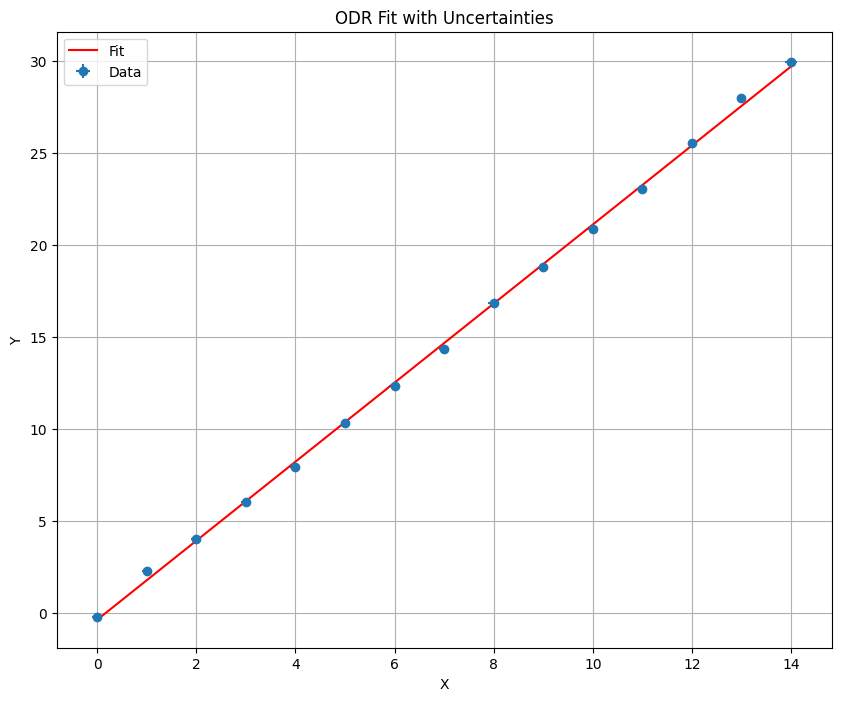

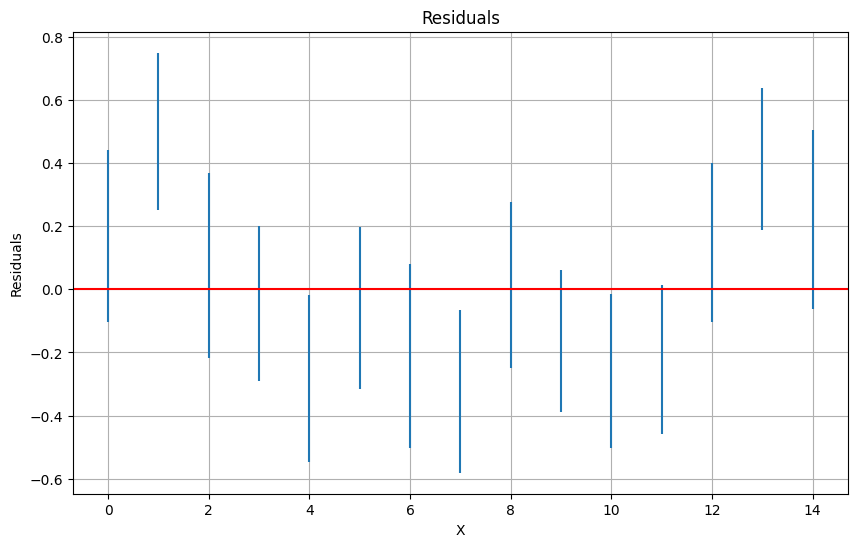

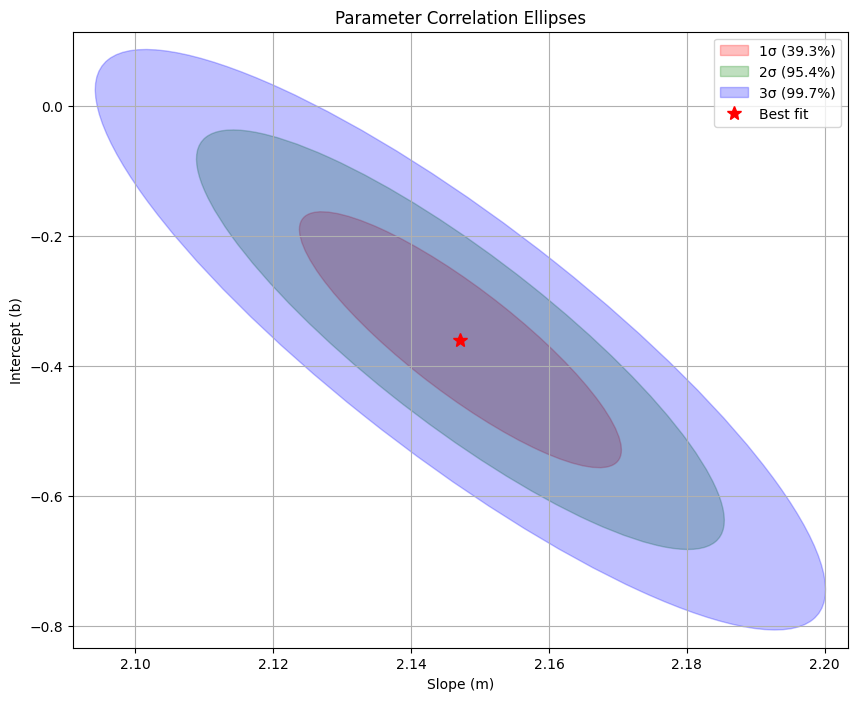

In [16]:
results = analyze_data_with_odr(x, dx, y, dy)

In [17]:
print("Fit Results:")
print(f"Slope: {results['slope'][0]:.6f} ± {results['slope'][1]:.6f}")
print(f"Intercept: {results['intercept'][0]:.6f} ± {results['intercept'][1]:.6f}")
print(f"\nGoodness of fit:")
print(f"Chi-square: {results['chi_square']:.6f}")
print(f"Reduced chi-square: {results['reduced_chi_square']:.6f}")
print(f"P-value: {results['p_value']:.6f}")

Fit Results:
Slope: 2.147160 ± 0.016329
Intercept: -0.359677 ± 0.137575

Goodness of fit:
Chi-square: 14.627831
Reduced chi-square: 1.125218
P-value: 0.331159
